<center> <h2> Classification multimodale à l'aide d'images et de texte </h2> 
<h3>Modèle InceptionV3 + BERT/LSTM</h3>
</center>

<p>Dans ce notebook nous allons fusionner deux modèles pour resoudre un problème de classification d'images et de texte a fin de répondre au challenge : (https://challengedata.ens.fr/challenges/59)<p>

  
Les grandes étapes dans le notebook sont :
1. Import des librairies
2. Configuration de Google Colaboratory : préparation de l'environnement des données (chemin et copie)
3. Configuration des paramètres utilisés par les modèles
4. Traitement des données textuelles
5. Traitement des données images
6. Pour chaque sous modèle :
    - Mise en forme des données (format/normalisation)
    - Création du modèle
    - Compilation du modèle
7. Pour le multimodèle
    - Mise en forme des données
    - Fit du modèle
    - Calcul des perfermances
    - Visualisation des performances
    - Evaluation sur un jeu de test avec labels connus

# 1 Connection GPU/TPU Google

In [4]:
# Connexction au GPU du google

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  

Mon Jun  5 13:06:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# # Connexction au TPU du google
# import tensorflow as tf

# print("Tensorflow version " + tf.__version__)

# # NEW on TPU in TensorFlow 2.4: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()           # TPU detection
#   #strategy = tf.distribute.TPUStrategy(tpu)
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:                                                    # detect GPUs              
#   #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
#   #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
#   #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.TPUStrategy(tpu)

# print("Number of accelerators: ", strategy.num_replicas_in_sync)


In [6]:
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))


Your runtime has 13.6 gigabytes of available RAM


# 2 Installation

In [7]:
# Install BERT for tf2 module
!pip install bert-for-tf2
# Install Keras version 2.8
!pip install keras==2.12.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install pydot
!pip3 install pydotplus
!pip3 install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
#Transformers
!pip install sentencepiece # a faire avant !! Sinon retourne une erreur lors de la tokenisation
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.4 MB/s eta 0:00:00


# 3 Importation des librairies nécessaires

In [10]:
# Base
import os
import shutil
import numpy as np
import pandas as pd
import re
import string
import unicodedata
import cv2
import sys
import pickle
import glob
import random
from tqdm.notebook import tqdm
import logging
tqdm.pandas()

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Tensorflow
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import tensorflow_hub as hub

import bert

#from official.nlp import optimization  # to create AdamW optimizer

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image, ImageChops #

from tqdm import tqdm # see: https://github.com/tqdm/tqdm#readme
import joblib #

from IPython.core.pylabtools import figsize #

# Google Colab
from google.colab import drive
%tensorflow_version 2.x

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

print("Modules importation successful")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Modules importation successful


# 4 Configuration

In [11]:
# CHECK PYTHON VERSION
print(f"\n>> Python version:\n {sys.version}")

# CHECK TENSORFLOW VERSION
print(f"\n>> TensorFlow version:\n {tf.version.VERSION}")

# CHECK TENSORBOARD HUB
print("\nHub version: ", hub.__version__)

# Check is Link to Drive is OK`
from google.colab import drive
print("\n>> Google Drive:")
drive.mount('/content/drive/')
!if [ -d '/content/drive' ]; then echo "Connection to Google drive successful" ; else echo "Error to connect to Google drive"; fi




>> Python version:
 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]

>> TensorFlow version:
 2.12.0

Hub version:  0.13.0

>> Google Drive:
Mounted at /content/drive/
Connection to Google drive successful


In [12]:
path_cwd = os.getcwd()
logger = logging.getLogger(__name__)

print(os.getcwd())
print(sys.executable)
print(sys.version)
print(sys.version_info)


/content
/usr/bin/python3
3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


In [13]:
# IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
# if IS_COLAB_BACKEND:
#   from google.colab import auth
#   # Authenticates the Colab machine and also the TPU using your
#   # credentials so that they can access your private GCS buckets.
#   auth.authenticate_user()
# project_id = 'Rakuten_API'
# !gcloud config set project {project_id}
# os.environ["GOOGLE_CLOUD_PROJECT"] = project_id


## 4.1 Chargement des données dans Google drive

In [14]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Rakuten_API/datas/images/image_train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

with zipfile.ZipFile('/content/drive/MyDrive/Rakuten_API/datas/images/image_test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')


In [15]:
# Switch to bash (cell-wise)
%%bash

# Images source and destination
SRC1="/content/drive/MyDrive/Rakuten_API/datas/images/image_train.zip"
SRC2="/content/drive/MyDrive/Rakuten_API/datas/images/image_test.zip"

# make a data directory
# try:
#   DEST = os.mkdir('/Rakuten_API/tmp')
# except OSError:
#   pass

#
DEST_TRAIN="/Rakuten_API/tmp"
#DEST_TEST="/tmp/Rakuten_API/"

#rm -r $DEST
# Check it has not been done
if [ -d "$DEST_TRAIN" ]; then
    echo "Images already unzipped"
else
    # Create directory
    mkdir -p "$DEST_TRAIN"
    #mkdir -p "$DEST_TEST"
    # Unzip images
    unzip -q "$SRC1" -d "$DEST_TRAIN"
    unzip -q "$SRC2" -d "$DEST_TRAIN"
    echo "Images unzipped"
fi
#!wget /content/drive/My Drive/Rakuten_API/datas/images/image_train
#!unzip image_train.zip

#os.chdir('/tmp/Rakuten_API/datas/images/')
#!ls


Images unzipped


In [16]:
# Les chemins vers les jeux de données et sauvegardes (à adapter personnellement)
inRep = r"/content/drive/MyDrive/Rakuten_API/datas/"
outRep = r"/content/drive/MyDrive/Rakuten_API//output/"
train_path = r"/Rakuten_API/tmp/image_train/"
test_path = r"/Rakuten_API/tmp/image_test/"
#checkpoint_dir = r"/tmp/Rakuten_API/classification/models/"
model_savepath    = r"/Rakuten_API/output/save_model/"


## 4.2 Chargement du modèle bert HUB

In [17]:
# Import the BERT BASE model from Tensorflow HUB (layer, vocab_file and tokenizer)
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer    = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable = True, name = 'BERT_encoder')

# with strategy.scope():
#     # New on TPU in TensorFlow 2.4: this setting allows you to load models from TF Hub directly to the TPU
#     load_locally = tf.saved_model.LoadOptions(experimental_io_device = '/job:localhost')
#   # m = tf.keras.Sequential([
#   #   hub.KerasLayer(
#   #     "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
#   #     output_shape=[1280],
#   #     load_options=load_locally,
#   #     trainable=False, name = 'BERT_encoder'),  # Can be True, see below.
#   #   tf.keras.layers.Dense(num_classes, activation='softmax')
#   # ])
#     bert_layer = hub.KerasLayer( "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", 
#                                 trainable = True,
#                                 load_options = load_locally,
#                                 name = 'BERT_encoder')
  
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case   = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer       = BertTokenizer(vocabulary_file, to_lower_case)



# 5 Chargement des données

In [18]:
# Données d'entrée (lecture seule)
X_train = pd.read_csv(inRep + 'X_train_update.csv', index_col = 0)
Y_train = pd.read_csv(inRep + 'Y_train_CVw08PX.csv', index_col = 0)
X_test  = pd.read_csv(inRep + 'X_test_update.csv', index_col = 0)

#reconstituion du lien des images
files = glob.glob(train_path + '/*.jpg')

# X_train['pathname'] = X_train.apply(lambda x : train_path + "/image_"+str(x['imageid']) + "_product_" + str(x['productid']) + ".jpg", axis=1)
# X_test['pathname'] = X_test.apply(lambda x : test_path + "/image_"+str(x['imageid']) + "_product_" + str(x['productid']) + ".jpg", axis=1)

X_train['pathname'] = X_train.apply(lambda x : "gs://multimodal_rakuten/images/image_train/image_"+str(x['imageid']) + "_product_" + str(x['productid']) + ".jpg", axis=1)
X_test['pathname'] = X_test.apply(lambda x : "gs://multimodal_rakuten/images/image_test/image_"+str(x['imageid']) + "_product_" + str(x['productid']) + ".jpg", axis=1)

X_train['filename'] = X_train.apply(lambda x : "image_" + str(x['imageid']) + "_product_" + str(x['productid']) + ".jpg", axis=1)
X_test['filename'] = X_test.apply(lambda x : "image_" + str(x['imageid']) + "_product_" + str(x['productid']) + ".jpg", axis=1)


# Renomé la variable 'prdtypecode'
Y_train.rename(columns={'prdtypecode': 'labels'}, inplace=True)
#Y_train.columns

df_train = pd.concat([X_train, Y_train], axis = 1)
df_test = X_test

# Display of a few lines of the df containing images and labels
display(df_train.head(5))



,designation,description,productid,imageid,pathname,filename,labels
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,gs://multimodal_rakuten/images/image_train/ima...,image_1263597046_product_3804725264.jpg,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,gs://multimodal_rakuten/images/image_train/ima...,image_1008141237_product_436067568.jpg,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,gs://multimodal_rakuten/images/image_train/ima...,image_938777978_product_201115110.jpg,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,gs://multimodal_rakuten/images/image_train/ima...,image_457047496_product_50418756.jpg,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,gs://multimodal_rakuten/images/image_train/ima...,image_1077757786_product_278535884.jpg,2705


In [19]:
display(df_test.head(5))


,designation,description,productid,imageid,pathname,filename
84916,Folkmanis Puppets - 2732 - Marionnette Et Théâ...,NaN,516376098,1019294171,gs://multimodal_rakuten/images/image_test/imag...,image_1019294171_product_516376098.jpg
84917,Porte Flamme Gaxix - Flamebringer Gaxix - 136/...,NaN,133389013,1274228667,gs://multimodal_rakuten/images/image_test/imag...,image_1274228667_product_133389013.jpg
84918,Pompe de filtration Speck Badu 95,NaN,4128438366,1295960357,gs://multimodal_rakuten/images/image_test/imag...,image_1295960357_product_4128438366.jpg
84919,Robot de piscine électrique,<p>Ce robot de piscine d&#39;un design innovan...,3929899732,1265224052,gs://multimodal_rakuten/images/image_test/imag...,image_1265224052_product_3929899732.jpg
84920,Hsm Destructeur Securio C16 Coupe Crois¿E: 4 X...,NaN,152993898,940543690,gs://multimodal_rakuten/images/image_test/imag...,image_940543690_product_152993898.jpg


In [20]:
# keep only files that exist
# df_test['keep'] = df_test.apply(lambda x : os.path.exists(str(x['pathname'])), axis=1)
# df_test = df_test[df_test['keep'] == True]
# df_train['keep'] = df_train.apply(lambda x : os.path.exists(str(x['pathname'])), axis=1)
# df_train = df_train[df_train['keep'] == True]


In [21]:
#création du dataset final pour le model
df_train['text'] = df_train.apply(lambda x: str(x['designation']) + ' ' + str(x['description']), axis = 1)
df_test['text'] = df_test.apply(lambda x: str(x['designation']) + ' ' + str(x['description']), axis = 1)

#drop des features inutiles
# df_train = df_train.drop(['designation', 'description', 'filename'], axis = 1)
# df_test = df_test.drop(['designation', 'description', 'filename'], axis = 1)

#ordonnée les colonnes text, filename, labels
df_train = df_train[['text','filename','labels']]
df_test = df_test[['text', 'filename']]

df_train['text'] = df_train['text'].astype(str).str.replace('nan', '')
df_test['text'] = df_test['text'].astype(str).str.replace('nan', '')

df_train = df_train.sample(frac=1)

print(df_train.shape)
print(df_test.shape)

# Simple Latex table
#pd.options.display.latex.repr  = True
#display(df_train.head(5))

display(df_train.head(5))


(84916, 3)
(13812, 2)


<ipython-input-21-664d8bcd444a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['text'] = df_test['text'].astype(str).str.replace('nan', '')


,text,filename,labels
81300,Bob L'eponge + Les Razmoket - 2 Jeu En 1,image_282922689_product_6215953.jpg,40
21998,Lame Support Protection Hélice Fixator Porte P...,image_1277499039_product_4019796707.jpg,1300
23368,Athènes Une Démocratie De Sa Naissance À Sa Mort,image_876333517_product_81983829.jpg,10
70421,Mister No 106 107 108 109 110 Aventures Et Voy...,image_1191557420_product_3109819937.jpg,2403
31396,Lot De 6 Tabouret De Bar Chaise De Salon Snack...,image_1157669706_product_2688143421.jpg,1560


In [22]:
dict_label = dict(zip(df_train.labels.unique(), range(1, df_train.labels.nunique()+1)))


In [23]:
df_train.labels = df_train.labels.map(dict_label)


In [24]:
train_path

'/Rakuten_API/tmp/image_train/'

In [25]:
names_train = [os.path.basename(x) for x in glob.glob(train_path + '*.jpg')]
names_test = [os.path.basename(x) for x in glob.glob(test_path + 'image_' + '*.jpg')]

train_not_found = list(set(names_train) - set(df_train['filename'].unique()))
test_not_found = list(set(names_test) - set(df_test['filename'].unique()))


In [26]:
print("df_train :", len(names_train), len(df_train['filename'].unique()))
print("df_test :", len(names_test), len(df_test['filename'].unique()))


df_train : 84916 84916
df_test : 13812 13812


In [27]:
# Distribution des 27 classes
#df_train.labels.value_counts()

df_vis2 = round(df_train["labels"].value_counts(normalize=True)*100,2).rename_axis("labels").to_frame("counts %")


In [28]:
# Le tableau
print("pourcentage des produits par catégorie(%): ")

display(df_vis2)


pourcentage des produits par catégorie(%): 


,counts %
labels,
10,12.02
5,5.97
2,5.94
15,5.88
6,5.88
20,5.74
4,5.62
12,5.61
17,5.07


Text(0.5, 1.0, 'pourcentage des produits par catégorie')

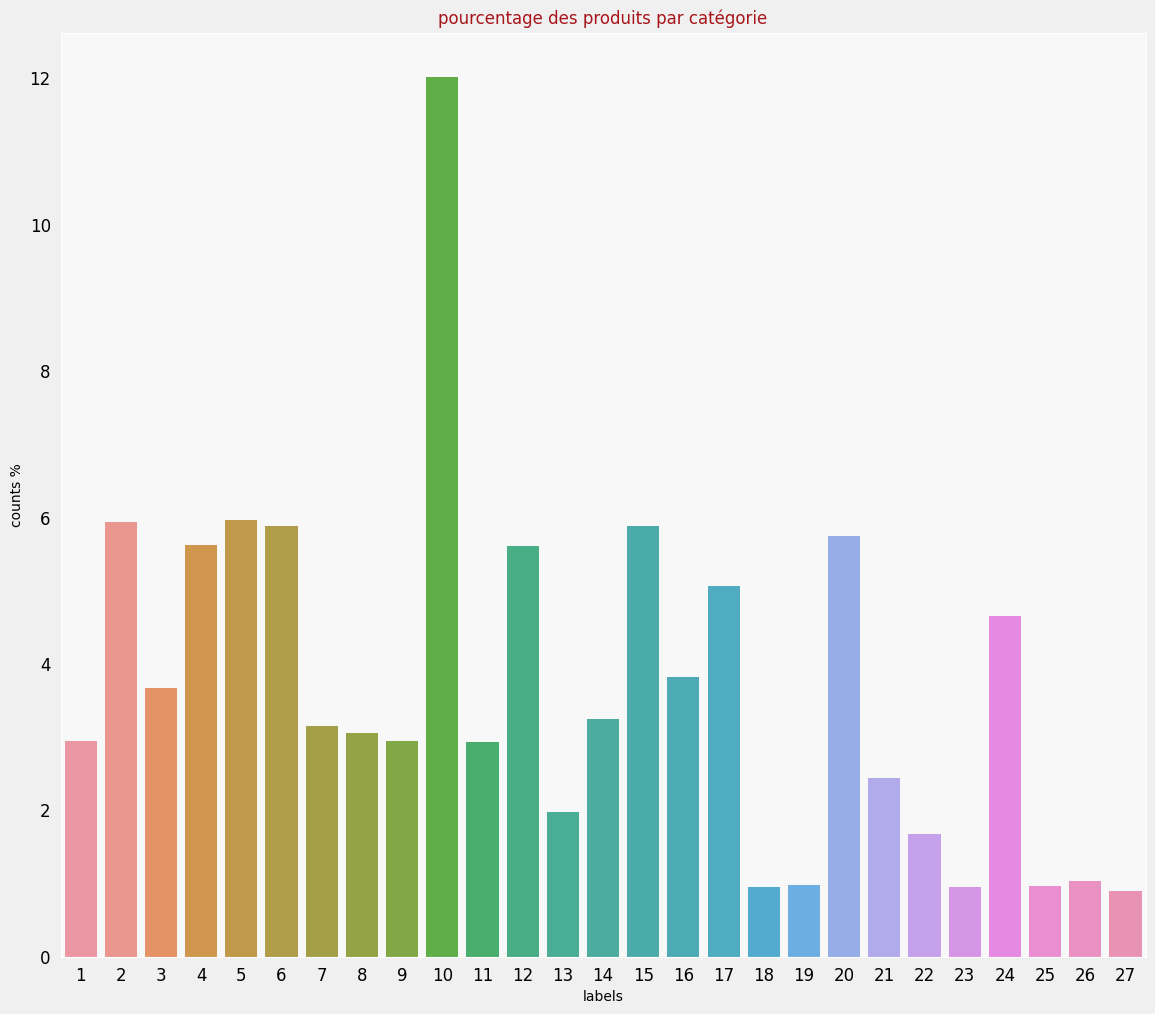

In [29]:
# Le graphe
plt.figure(figsize = (14,12))

sns.barplot(data = df_vis2.reset_index(), x = "labels", y = "counts %")
plt.title("pourcentage des produits par catégorie")


# 6 Traitement des données
## 6.1 Traitement des données textuelles
Prétraitement des textes selon BERT et nettoyage des textes.
Il est toujours utile d'avoir une idée du nombre de mots que les échantillons de texte ont tendance à contenir. Le moyen le plus simple d'obtenir des statistiques sur le texte peut être de diviser le texte en espaces, " ", de calculer la longueur de la liste résultante et d'appeler la méthode Pandas describe() sur la série.

In [30]:
df_train.text.map(lambda text: len(text.split(" "))).describe()


count    84916.000000
mean        92.764402
std        117.273162
min          5.000000
25%         12.000000
50%         49.000000
75%        138.000000
max       2078.000000
Name: text, dtype: float64

<ipython-input-31-071cf31d893b>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word_count)


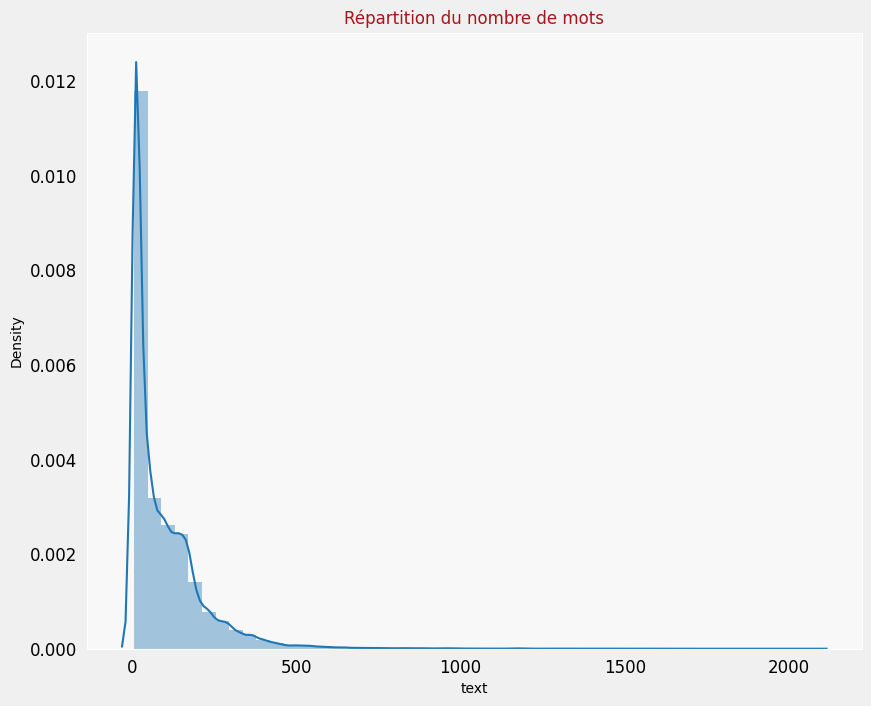

In [31]:
# Distrbution du nombre de mots par lignes
word_count = df_train.text.apply(lambda x : len(x.split(' ')))

plt.figure(figsize = (10,8))

sns.distplot(word_count)

plt.title("Répartition du nombre de mots")

plt.show()


In [32]:
stop_words_update = stopwords.words('english')

stop_words = stopwords.words('french')
stop_words.append(stop_words_update)

# Convertit le fichier unicode en ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def remove_tags(text):
    return TAG_RE.sub('', text)

TAG_RE = re.compile(r'<[^>]+>')

def preprocess_text(sen):
    #sentence = unicode_to_ascii(sen.lower().strip())
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sentence.lower()

    return sentence

In [33]:
df_train.text = df_train.text.apply(lambda x :preprocess_text(x))
df_test.text = df_test.text.apply(lambda x :preprocess_text(x))

display(df_train.head())

<ipython-input-33-fd67a2510963>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.text = df_test.text.apply(lambda x :preprocess_text(x))


,text,filename,labels
81300,bob eponge les razmoket jeu en,image_282922689_product_6215953.jpg,1
21998,lame support protection lice fixator porte pou...,image_1277499039_product_4019796707.jpg,2
23368,ath nes une mocratie de sa naissance sa mort,image_876333517_product_81983829.jpg,3
70421,mister no aventures et voyages,image_1191557420_product_3109819937.jpg,4
31396,lot de tabouret de bar chaise de salon snack c...,image_1157669706_product_2688143421.jpg,5


In [34]:
df_train.set_index('filename', inplace =True)
df_test.set_index('filename', inplace =True)


In [35]:
vec_preprocess_text = np.vectorize(preprocess_text)


In [36]:
def get_tokens(text, tokenizer):
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]
    return tokens, length  

def get_masks(text, tokenizer, max_length):
    """Mask for padding"""
    tokens, length = get_tokens(text, tokenizer)
    return np.asarray([1]*len(tokens) + [0] * (max_length - len(tokens)))

vec_get_masks = np.vectorize(get_masks, signature = '(),(),()->(n)')

def get_segments(text, tokenizer, max_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    tokens, length = get_tokens(text, tokenizer)
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.asarray(segments + [0] * (max_length - len(tokens)))

vec_get_segments = np.vectorize(get_segments, signature = '(),(),()->(n)')

def get_ids(text, tokenizer, max_length):
    """Token ids from Tokenizer vocab"""
    tokens, length = get_tokens(text, tokenizer)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = np.asarray(token_ids + [0] * (max_length-length))
    return input_ids

vec_get_ids = np.vectorize(get_ids, signature = '(),(),()->(n)')

def get_texts(path):
    path = path.decode('utf-8')
    parts = path.split(os.sep)
    image_name = parts[-1]
    
    is_train = parts[-2] == 'image_train'
    if is_train:
        df = df_train
    else:
        df = df_test
    
    text = df['text'][image_name]
    return text

vec_get_text = np.vectorize(get_texts)

def prepare_text(paths):
    #Preparing texts
    
    texts = vec_get_text(paths)
    
    text_array = vec_preprocess_text(texts)
    ids = vec_get_ids(text_array, 
                      tokenizer, 
                      max_length).squeeze().astype(np.int32)
    masks = vec_get_masks(text_array,
                          tokenizer,
                          max_length).squeeze().astype(np.int32)
    segments = vec_get_segments(text_array,
                                tokenizer,
                                max_length).squeeze().astype(np.int32)
    
    return ids, segments, masks

def clean(i, tokens):
    try:
        this_token = tokens[i]
        next_token = tokens[i+1]
    except:
        return tokens
    if '##' in next_token:
        tokens.remove(next_token)
        tokens[i] = this_token + next_token[2:]
        tokens = clean(i, tokens)
        return tokens
    else:
        i = i+1
        tokens = clean(i, tokens)
        return tokens
    
def clean_text(array):
    array = array[(array!=0) & (array != 101) & (array != 102)]
    tokens = tokenizer.convert_ids_to_tokens(array)
    tokens = clean(0, tokens)
    text = ' '.join(tokens)
    return text

## 6.2 Traitement des données images
Nous allons maintenant charger et examiner les tailles de quelques images à partir des données d'entraînement.

In [37]:
# Images preprocessing
def load_image(path):
    
    path = path.decode('utf-8')
    image = cv2.imread(path)
    image = cv2.resize(image, (img_width, img_height))
    image = image/255
    image = image.astype(np.float32)
    parts = path.split(os.sep)
    labels = df_train.loc[parts[-1], 'labels'] == Classes 
    labels = labels.astype(np.int32)
    
    return image, labels
    
vec_load_image = np.vectorize(load_image, signature = '()->(r,c,d),(s)')


In [38]:
# Affichage de quelquesimages aléatoirement
#path =  glob('/Rakuten_API/tmp/image_train/**')
#train_path = r"/Rakuten_API/tmp/image_train/"
def plotImages2(nb_lin, nb_col):
    i = 1
    nb_images = nb_lin * nb_col
    
    plt.figure(figsize = (12,10))

    for r in random.sample(glob.glob(train_path + 'image_' + '*.jpg'), nb_images):
      plt.subplot(nb_lin, nb_col, i)
      
      img = cv2.imread(r)
      img = tf.reverse(img, axis=[-1])
      img = tf.image.adjust_contrast(img, 1.35)

      plt.imshow(img)
      
      i += 1
      
      plt.axis('off')


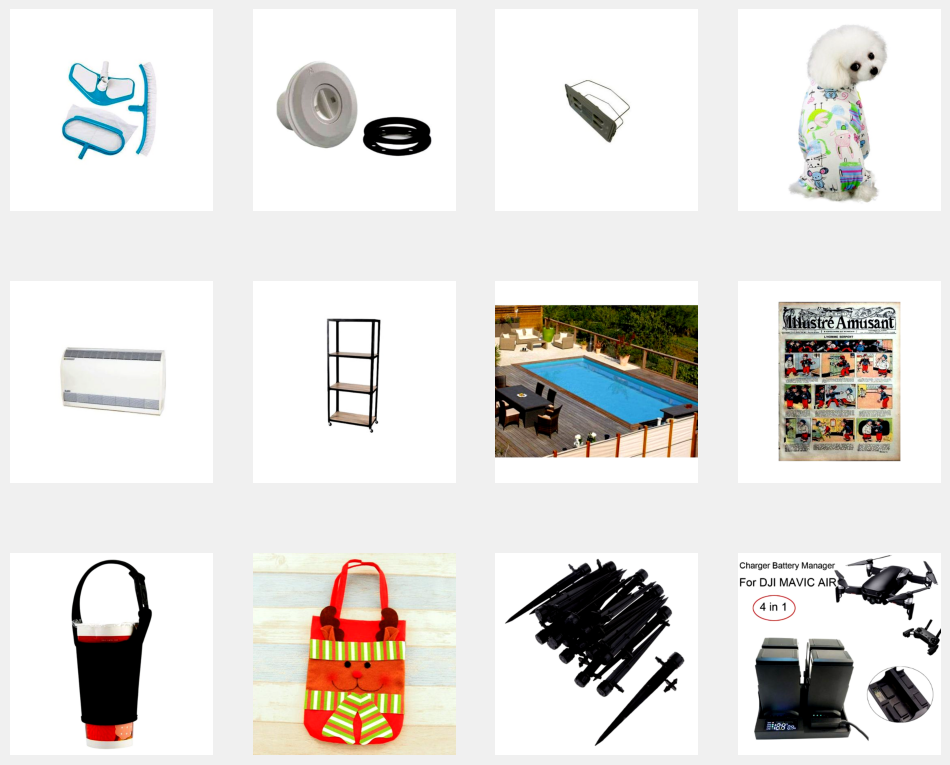

In [39]:
# affichage de 9 images 3x3
plotImages2(3, 4)


In [40]:
# Dataset creation
def prepare_data(paths):

    #Images and labels
    images, labels = tf.numpy_function(vec_load_image, [paths], [tf.float32, tf.int32])
    
    [ids, segments, masks, ] = tf.numpy_function(prepare_text, [paths], [tf.int32, tf.int32, tf.int32])

    images.set_shape([None, img_width, img_height, depth])
    labels.set_shape([None, nClasses])
    ids.set_shape([None, max_length])
    masks.set_shape([None, max_length])
    segments.set_shape([None, max_length])
    return ({"input_word_ids": ids, "input_mask": masks, "segment_ids": segments, "image": images}, {"class": labels})
    

    return dataset


In [41]:
display(df_train.head(5))


,text,labels
filename,,
image_282922689_product_6215953.jpg,bob eponge les razmoket jeu en,1
image_1277499039_product_4019796707.jpg,lame support protection lice fixator porte pou...,2
image_876333517_product_81983829.jpg,ath nes une mocratie de sa naissance sa mort,3
image_1191557420_product_3109819937.jpg,mister no aventures et voyages,4
image_1157669706_product_2688143421.jpg,lot de tabouret de bar chaise de salon snack c...,5


In [42]:
# ---------------------------------------------------------------------------
# Configuration des paramètres principaux du modèle
# ---------------------------------------------------------------------------
# Parameters setting: images width and height, depth, number if classes, input shape
batch_size =  80

# Redution de la taille des images 
img_width = 299
img_height = 299

depth = 3
max_length = 20 #Setup according to the text

nClasses = df_train.labels.nunique()
Classes = df_train.labels.unique()
#filesName = df_train.filename.unique()
input_shape = (img_width, img_height, depth)


In [43]:
input_shape


(299, 299, 3)

In [44]:
train_path


'/Rakuten_API/tmp/image_train/'

In [45]:
# # Images loading using tf.data
def tf_data(path, batch_size):

    paths = tf.data.Dataset.list_files(path)
    paths = paths.batch(64)
    
    dataset = paths.map(prepare_data, tf.data.experimental.AUTOTUNE)
    
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.unbatch()
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    
    return dataset   

#files = "gs://Rakuten_API/tmp/image_train/image_" + "*.jpg"
#train_path + "/image_"+str(x['imageid']) + "_product_" + str(x['productid']) + ".jpg"
data_train = tf_data(train_path + "image_" + "*.jpg", batch_size)
data_test = tf_data(test_path + "image_" + '*.jpg', batch_size)


In [46]:
data_train


<_RepeatDataset element_spec=({'input_word_ids': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), 'segment_ids': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), 'image': TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None)}, {'class': TensorSpec(shape=(None, 27), dtype=tf.int32, name=None)})>

## 6.3 Visualusation des images/texte
Tracez quelques exemples d'images avec du texte associé

In [47]:
#ip, op = next(iter(data_train))


In [48]:
ip, op = next(iter(data_train))
images = ip['image'][:16]
input_word_ids = ip['input_word_ids'][:16]
true_labels =  op['class'][:16]


In [ ]:
# Print images and related texts before classification
i=1
texts = [clean_text(array) for array in input_word_ids.numpy()]
plt.figure(figsize=(30,30))
for image, label, text in zip(images.numpy(), true_labels.numpy(), texts):
    plt.subplot(4, 4, i)
    i+=1
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title("{}\nCategory: {}".format(text, Classes[label.argmax(0)]))
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# 7 Modèle de classification
Pour triter ce type de données doubles images/texte nous allons créer pour chque données son modèle et puis le multimodèle viendra pour concatiner les deux.

## 7.1 Compilation du modèle image

In [49]:
# Images Model
model_cnn = models.Sequential()
model_cnn.add(InceptionV3(weights = 'imagenet', include_top = False, input_tensor = layers.Input(shape = (299, 299, 3))))
model_cnn.add(layers.AveragePooling2D(pool_size = (8, 8), name = 'AVG_Pooling'))
model_cnn.add(layers.Dropout(.4, name = 'Dropout_0.4'))
model_cnn.add(layers.Flatten(name = 'Flatten'))
model_cnn.add(layers.Dense(128, name = 'Dense_128'))


87910968/87910968 [==============================] - 1s 0us/step


In [50]:
# Keep model layers trainable
for layer in model_cnn.layers:
    layer.trainable = True
    

In [51]:
model_cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 AVG_Pooling (AveragePooling  (None, 1, 1, 2048)       0         
 2D)                                                             
                                                                 
 Dropout_0.4 (Dropout)       (None, 1, 1, 2048)        0         
                                                                 
 Flatten (Flatten)           (None, 2048)              0         
                                                                 
 Dense_128 (Dense)           (None, 128)               262272    
                                                                 
Total params: 22,065,056
Trainable params: 22,030,624
Non-trainable params: 34,432
_______________________________________

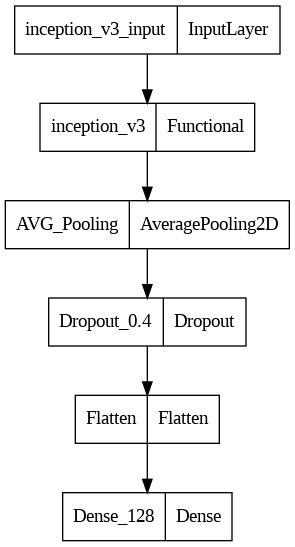

In [52]:
plot_model(model_cnn, to_file='model_cnn.png')


## 7.2 Compilation du modèle texte

In [53]:
# Bert + LSTM text model
input_ids      = layers.Input(shape = (max_length,), dtype=tf.int32, name = "input_word_ids")
input_masks    = layers.Input(shape = (max_length,), dtype=tf.int32, name = "input_masks")
input_segments = layers.Input(shape = (max_length,), dtype=tf.int32, name = "segment_ids")
_, seq_out     = bert_layer([input_ids, input_masks, input_segments])

out        = layers.LSTM(128, name = 'LSTM')(seq_out)
model_lstm = models.Model([input_ids, input_masks, input_segments], out)


In [54]:
# Keep the Bert + LSTM layers trainable
for layer in model_lstm.layers:
    layer.trainable = True
    

In [55]:
model_lstm.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 20)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 20)]         0           []                               
                                                                                                  
 BERT_encoder (KerasLayer)      [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 20, 768)]                 'input_masks[0][0]',        

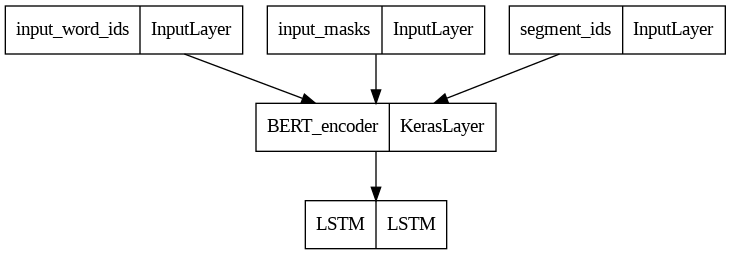

In [56]:
plot_model(model_lstm, to_file = 'bert_lstm.png')


## 7.3 Modèle de concaténation

In [57]:
# Stacking early-fusion multimodal model
input_word_ids = layers.Input(shape = (max_length,), dtype = tf.int32, name = "input_word_ids")
input_mask = layers.Input(shape = (max_length,), dtype = tf.int32, name = "input_mask")
segment_ids = layers.Input(shape = (max_length,), dtype = tf.int32, name = "segment_ids")
image_input = layers.Input(shape = input_shape, dtype = tf.float32, name = "image")

image_side = model_cnn(image_input)
text_side = model_lstm([input_word_ids, input_mask, segment_ids])

# Concatenate features from images and texts
merged = layers.Concatenate()([image_side, text_side])
merged = layers.Dense(256, activation = 'relu')(merged)
output = layers.Dense(nClasses, activation = 'softmax', name = "class")(merged)


In [58]:
model = models.Model([input_word_ids, input_mask, segment_ids, image_input], output)


In [59]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_word_ids (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 20)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 20)]         0           []                         

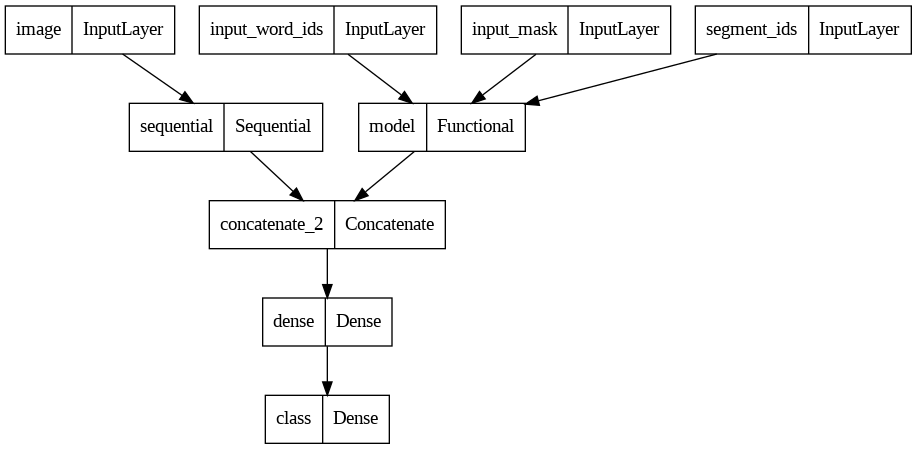

In [60]:
plot_model(model, to_file='multimodal.png')


In [61]:
# Stochastic Gradient Descent optimizer
sgd = optimizers.SGD(learning_rate = 0.0001, momentum = 0.9, nesterov = False)

# Compile model
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])


In [62]:
# Setup callbacks, logs and early stopping condition
checkpoint_path = "stacking_early_fusion/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"

cp = callbacks.ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy', save_best_only = True, verbose = 1, mode = 'max')
csv_logger = callbacks.CSVLogger('stacking_early_fusion/stacking_early.log')
es = callbacks.EarlyStopping(patience = 3, restore_best_weights = True)


In [63]:
# Reduce learning rate if no improvement is observed
reduce_lr = callbacks.ReduceLROnPlateau( monitor = 'val_accuracy', factor = 0.1, patience = 1, min_lr = 0.00001)
     

In [64]:
# Training
history = model.fit(data_train,
                    epochs = 10,
                    steps_per_epoch = df_train.shape[0]//batch_size,
                    validation_data = data_test,
                    validation_steps = df_test.shape[0]//batch_size,
                    callbacks = [cp, csv_logger, reduce_lr]
                    )


Epoch 1/10
1061/1061 [==============================] - ETA: 0s - loss: 2.6473 - accuracy: 0.2751

UnknownError: ignored

## 7.4 Sauvegarde et rechargez votre modèle formé

In [ ]:
# Save to Tensorflow SavedModel
#model.save("./formats/tf_savedmodel", save_format = 'tf')

# Save to HDF5
model.save(model_savepath + 'multimodel.h5', save_format = 'h5')

#model.save('multimodel.h5')

# Reload it with:
#reloaded_model = tf.keras.models.load_model('multimodel.h5')

## 7.5 Calcul des perfermances

In [ ]:
# Plot training and test accuracy using Plotly library
df = pd.read_csv('stacking_early_fusion/stacking_early.log')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['epoch'], y=df['accuracy'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df['epoch'], y=df['val_accuracy'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
# Plot training and test loss using Plotly library
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['epoch'], y=df['loss'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df['epoch'], y=df['val_loss'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
# Model evaluation on test set
model.evaluate(data_test, steps = test.shape[0]//batch_size)

## 7.6 Tracez quelques prédictions

In [ ]:
ip, op = next(iter(data_test))
images = ip['image'][:16]

input_masks = ip['input_mask'][:16]
input_word_ids = ip['input_word_ids'][:16]
input_segments = ip['segment_ids'][:16]

true_labels =  op['class'][:16]

In [ ]:
pred_labels = model.predict([input_word_ids,
                             input_masks,
                             input_segments,
                             images])


In [ ]:
i=1
texts = [clean_text(array) for array in input_word_ids.numpy()[:16]]
plt.figure(figsize=(30,30))
for image, actual_label, label, text in zip(images.numpy()[:16], true_labels.numpy()[:16], pred_labels, texts):
      plt.subplot(4,4,i)
      i+=1
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.imshow(image)
      plt.axis('off')
      plt.title("Text: {}\n Actual: {}\n Predicted: {}".format(text, Classes[actual_label.argmax(0)], Classes[label.argmax(0)]))
      plt.xlabel(text)
plt.show()


# 8 Prédictions sur des données non labelisées

# 9 Conclusion : classification des images du répétoire test_images.
Echantillons d'images pédites sur le dataset test.